In [23]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, validation_curve
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score,
                             classification_report, roc_curve, auc, roc_auc_score)
from sklearn.model_selection import learning_curve


import matplotlib.pyplot as plt
import seaborn as sns

from mlxtend.plotting import plot_confusion_matrix, plot_learning_curves


%matplotlib inline

In [2]:
df = pd.read_csv('./credit-g.csv')

df = df.replace({'class': {'good': 1, 'bad': 0}}) # Changing text values to integer values

print(df.info())

df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
 other_payment_plans      1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
 foreign

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
680,no checking,6,existing paid,education,1538,<100,<1,1,female div/dep/mar,none,...,no known property,56,none,own,1,skilled,1,none,yes,1
432,<0,6,critical/other existing credit,furniture/equipment,1872,<100,unemployed,4,male single,none,...,no known property,36,none,for free,3,high qualif/self emp/mgmt,1,yes,yes,1
595,0<=X<200,6,all paid,new car,931,100<=X<500,<1,1,female div/dep/mar,none,...,life insurance,32,stores,own,1,unskilled resident,1,none,yes,0
107,0<=X<200,12,existing paid,new car,6078,<100,4<=X<7,2,male single,none,...,car,32,none,own,1,skilled,1,none,yes,1
865,no checking,15,existing paid,furniture/equipment,2221,500<=X<1000,1<=X<4,2,female div/dep/mar,none,...,car,20,none,rent,1,skilled,1,none,yes,1


## Data Processing & Feature Engineering

The dataset we have includes a number of categorical (nominal) features. We need to convert these features into a format usable by the model. We use OneHotEncoding to create a new feature for each value of a category present in the dataset.

For the numerical features in the dataset we scale the values using StandardScaler. 

I have used the Sklearn Pipeline & ColumnTransformer features to improve the reusability of the code.

In [3]:
cleaning_pipeline = ColumnTransformer(transformers=[
    ("categorical_transformer", OneHotEncoder(),
     ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'installment_commitment',
      'personal_status', 'other_parties', 'residence_since', 'property_magnitude', ' other_payment_plans',
      'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone', ' foreign_worker'
     ]),
    ("numerical_transformer", StandardScaler(), ['duration', 'credit_amount', 'age'])
])

pipe = Pipeline(steps=[
    ('cleaning', cleaning_pipeline),
    
    ('classification', LogisticRegression(solver='lbfgs'))])

## Train Test Split

To train and evaluate the model, I'm splitting the dataset into two different sets; the training set and the test set. The training set will be split multiple times using KFold cross-validation to understand variance within our training process, while the test set will be held out entirely until the model evaluation stage, so we can evaluate our trained model on data the model hasn't been trained on.

In [17]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

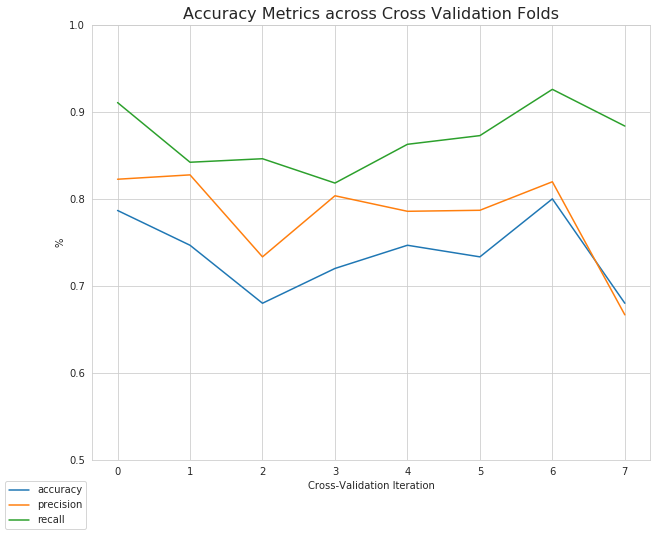

In [18]:
sns.set_style("whitegrid")

performance = []
for train_subset_index, test_index in KFold(n_splits=8).split(X_train):
    X_train_subset, X_test_subset = X.iloc[train_subset_index], X.iloc[test_index]
    y_train_subset, y_test_subset = y.iloc[train_subset_index], y.iloc[test_index]
    pipe.fit(X_train_subset, y_train_subset)
    y_pred = pipe.predict(X_test_subset)
    performance.append({
        'accuracy': accuracy_score(y_test_subset, y_pred),
        'recall': recall_score(y_test_subset, y_pred),
        'precision': precision_score(y_test_subset, y_pred)})

fig, ax = plt.subplots(figsize=(10, 8))

ax.plot([x['accuracy'] for x in performance], label='accuracy')
ax.plot([x['precision'] for x in performance], label='precision')
ax.plot([x['recall'] for x in performance], label='recall')

ax.set_ylim(.5, 1)
ax.set_ylabel('%')
ax.set_xlabel('Cross-Validation Iteration')
ax.set_title('Accuracy Metrics across Cross Validation Folds',
             fontdict={'fontsize': 16});

fig.legend(loc=3);

In [24]:
learning_curve(pipe, X_train, y_train, cv=8)

ValueError: Found unknown categories ['other'] in column 2 during transform

## Full Training Set

In [19]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

### Model Evaluation

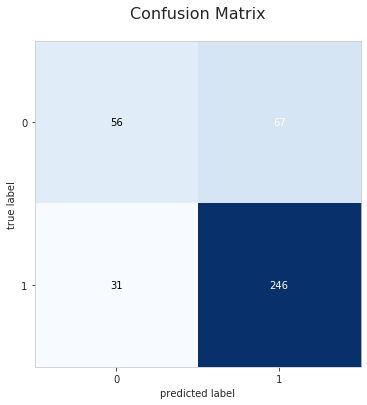

In [20]:
sns.set_style("whitegrid")

fig, ax = plot_confusion_matrix(
    conf_mat=confusion_matrix(y_test, y_pred, labels=[0, 1]),
    hide_spines=False, hide_ticks=False,
    figsize=(8, 6))

ax.set_title('Confusion Matrix',
             fontdict={'fontsize': 16});

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.46      0.53       123
           1       0.79      0.89      0.83       277

    accuracy                           0.76       400
   macro avg       0.71      0.67      0.68       400
weighted avg       0.74      0.76      0.74       400



#### Area Under ROC Curve

> Woo

Area under the curve score: 0.803


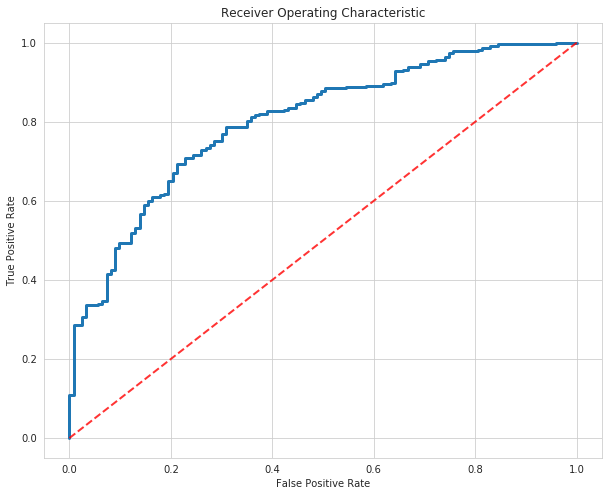

In [22]:
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(10, 8))
pred_proba = pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
auc_score = roc_auc_score(y_test, pred_proba)

ax.plot(fpr, tpr, lw=3)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
ax.set_title('Receiver Operating Characteristic')
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')

print('Area under the curve score: {x:0.3}'.format(x=auc_score))

### Next steps